### Week 6: K-means and Hierarchical Clustering
###### Joel Konitzer
###### 10/01/2022

In [36]:
#System packages
from datetime import datetime as dt
from datetime import timedelta as td
import time

#Required packages
import pandas as pd
import numpy as np
import re
import requests
import tweepy
from tweepy import OAuthHandler
from bs4 import BeautifulSoup
from scipy import stats
import seaborn as sns

#Custom functions
import fnTextProcressing
from credentials_Twitter import *

### Collect twitter data

##### Set up API request

In [19]:
bearer_token=bearer
consumer_key=client_key
consumer_secret=client_secret
access_token=access_token
access_token_secret=access_token_secret


endpoint = 'https://api.twitter.com/2/tweets/search/recent'
headers = {'authorization': f'Bearer {bearer_token}'}

params = {
    'query':  '#ETH', #Searching for hashtags that reference ETH, which is the Ethereum networks governance token
    'max_results': '100', #Max 100 results per request
    'tweet.fields': 'created_at,lang,public_metrics' #Included fields
}

#Function to create dataframe of interest
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text'],
        'lang': tweet['lang'],
        'public_metrics': tweet['public_metrics']
          
    }
    return data

##### Pull data

In [20]:
# Gather the last 7 days of tweets

dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = dt.strptime(now, dtformat)
    back_in_time = now - td(minutes=mins)
    return back_in_time.strftime(dtformat)
    
now = dt.now()  # get the current datetime, this is our starting point
last_week = now - td(days=1)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API
df_pulled = pd.DataFrame()  # initialize dataframe to store tweets
while True:
    if dt.strptime(now, dtformat) < last_week:
        # if we have reached 7 days ago, break the loop
        break
    pre60 = time_travel(now, 60)  # get 60 minutes before 'now'
    # assign from and to datetime parameters for the API
    params['start_time'] = pre60
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)  # send the request

    now = pre60  # move the window 60 minutes earlier
    # iteratively append our tweet data to our dataframe
    if 'data' in response.json():
        for tweet in response.json()['data']:
            row = get_data(tweet)  # we defined this function earlier
            df_pulled = df_pulled.append(row, ignore_index=True)
df = df_pulled

### Clean and Transform

In [22]:
#Expand public metrics
# Although I may not use these metrics for this analysis, I want to incorperate them into this dataset for future reference.
import json
df = pd.concat([df, df['public_metrics'].apply(pd.Series)], axis=1)
df = df.drop('public_metrics', axis=1)
df.head()

,id,created_at,text,lang,retweet_count,reply_count,like_count,quote_count
0,1576636407824908289,2022-10-02T18:13:06.000Z,RT @LVLLofficial: There are 14 member types in...,en,1310,0,0,0
1,1576636406667300869,2022-10-02T18:13:06.000Z,RT @LVLLofficial: There are 14 member types in...,en,1310,0,0,0
2,1576636405849415680,2022-10-02T18:13:06.000Z,RT @xaraneth: 🎉 SOL &amp; WHİTE LİST GIVEAWAY🎉...,en,3012,0,0,0
3,1576636404825993216,2022-10-02T18:13:06.000Z,RT @xaraneth: 🎉 SOL &amp; WHİTE LİST GIVEAWAY🎉...,en,3012,0,0,0
4,1576636402376540160,2022-10-02T18:13:05.000Z,RT @Stonylight: #DeFiWars is uniquely built to...,en,7,0,0,0


In [40]:
df.shape

(2400, 6)

Clean original data column
- Create two columns. One column will represent the clean text (removal of punctuation, capatal letters, stopwords). Second column will be a tokenized version of this column with the use of 'WordNetLemmatizer' - this is our target column for the feature vectorization in later steps

In [6]:
df_clean = df.copy()

#Clean summary
cleaned_summary = []
for t in df_clean['text']:
    cleaned_summary.append(fnTextProcressing.summary_cleaner(t))
    
#Tokenize
df_clean['text_clean'] = cleaned_summary
tokenizedtext = []
for t in df_clean['text_clean']:
    tokenizedtext.append(fnTextProcressing.tokenize(t))
    
df_clean['text_tokenized'] = tokenizedtext

In [8]:
#Preview dataframe
df_clean.head()

,id,created_at,text,lang,public_metrics,text_clean,text_tokenized
0,1576634487118495744,2022-10-02T18:05:28.000Z,RT @BabyYodaEmerson: Enjoying watching this fl...,en,"{'retweet_count': 50, 'reply_count': 0, 'like_...",rt babyyodaemerson enjoying watching this floo...,rt babyyodaemerson enjoying watching this floo...
1,1576634483414953985,2022-10-02T18:05:27.000Z,"RT @SabianNFT: $500 #ETH ✨ \n\n🔮 Like, Retweet...",en,"{'retweet_count': 1510, 'reply_count': 0, 'lik...",rt sabiannft eth like retweet follow me show m...,rt sabiannft eth like retweet follow me show m...
2,1576634482459021313,2022-10-02T18:05:27.000Z,@traveline_io Lets go #Trafeline 🚀🚀🚀🚀🚀🚀\n#bnb...,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",traveline io lets go trafeline bnb eth mlc cry...,traveline io let go trafeline bnb eth mlc crypto
3,1576634482278338561,2022-10-02T18:05:27.000Z,RT @0xNawarat: 🧐How to get the #Nawarat #ERAin...,en,"{'retweet_count': 10642, 'reply_count': 0, 'li...",rt xnawarat how to get the nawarat erainvitati...,rt xnawarat how to get the nawarat erainvitati...
4,1576634481896607744,2022-10-02T18:05:27.000Z,@1goonrich Kobura コイン #ETH #Utility\n\nCG Appl...,ja,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",goonrich kobura eth utility cg applied utility...,goonrich kobura eth utility cg applied utility...
...,...,...,...,...,...,...,...
2395,1576287014991048705,2022-10-01T19:04:45.000Z,RT @eneftiakademi: #EthereumNameService ( #ENS...,tr,"{'retweet_count': 2, 'reply_count': 0, 'like_c...",rt eneftiakademi ethereumnameservice ens alan ...,rt eneftiakademi ethereumnameservice en alan a...
2396,1576287014915379204,2022-10-01T19:04:45.000Z,RT @mvaygml00270774: @Imslave18 @goedhart_esth...,en,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",rt mvaygml imslave goedhart esther ishganjoor ...,rt mvaygml imslave goedhart esther ishganjoor ...
2397,1576287013359296518,2022-10-01T19:04:44.000Z,https://t.co/U0zoMgrenZ #WEB3 #ART #AI #DIGITA...,qme,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",https co zomgrenz web art ai digitalart degen ...,http co zomgrenz web art ai digitalart degen d...
2398,1576287006505639936,2022-10-01T19:04:43.000Z,"@cryptojack CheemsInu is not Next Shiba, \nShi...",et,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",cryptojack cheemsinu is not next shiba shiba i...,cryptojack cheemsinu is not next shiba shiba i...


In [25]:
# Add supporting columns like word count, sentence count, and stop word count
df_transformed = fnTextProcressing.supportingcols(df_clean)

### EDA

##### i. View top 10 words

In [ ]:
list_ = df_transformed.text_tokenized  
list_ = pd.Series(' '.join(list_).split()).value_counts().to_dict()
list(list_.items())[:10] #Return the top 10 words

[('rt', 2405),
 ('http', 1159),
 ('to', 1117),
 ('eth', 1114),
 ('co', 1111),
 ('the', 973),
 ('follow', 715),
 ('crypto', 591),
 ('giveaway', 571),
 ('nft', 534)]

##### ii. Top 10 ngram (selecting 4)

In [28]:
import nltk
tokens = ' '.join(df_transformed.text_tokenized ).split()
#Append as table column
ngram_list = pd.Series(nltk.ngrams(tokens, 4))
#Save as series for value count
ngram_values = ngram_list.value_counts()
ngram_dict = ngram_values.to_dict()
list(ngram_dict.items())[:10]

[(('crypto', 'community', 'in', 'the'), 107),
 (('community', 'in', 'the', 'next'), 106),
 (('rt', 'juancitopaya', 'giving', 'away'), 106),
 (('enter', 'rt', 'following', 'juancitopay'), 106),
 (('to', 'enter', 'rt', 'following'), 106),
 (('hr', 'to', 'enter', 'rt'), 106),
 (('next', 'hr', 'to', 'enter'), 106),
 (('the', 'next', 'hr', 'to'), 106),
 (('in', 'the', 'next', 'hr'), 106),
 (('juancitopaya', 'giving', 'away', 'to'), 106)]

iii. Generate wordcloud

In [33]:
from wordcloud import WordCloud

wc = WordCloud(width=1000, height=600, max_words=200).generate_from_frequencies(freq)

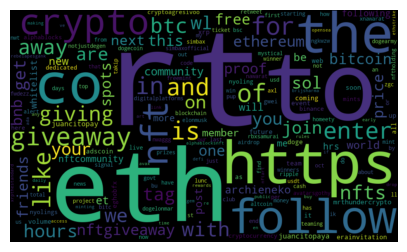

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Clustering
1. K-means
 * TfidfVectorizer
 * CountVectorizer
2. Hierarchical Clustering Analysis
 * CountVectorizer
 

#### K-means

In [29]:
#Selecting a subset of columns
feature_cols = ['id','created_at','text_clean','word_cnt','lang','char_cnt','text_tokenized','retweet_count', 'reply_count', 'like_count','quote_count']
df = df_transformed[feature_cols]

##### Model development

In [31]:
#Import required packages
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

##### Transforming text via TfidfTransformer

In [32]:
#Feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english")
X_tfidf = vectorizer.fit_transform(df.text_tokenized)

Determine the optimal number of clusters 

In [33]:
# fit the model for a range of 2 to 15 clusters
for n in range (2,15):
    # random_start makes the results reproducible 
    model = KMeans(n_clusters=n, random_state=42)
    model.fit(X_tfidf)
    # gather the predictions
    preds= model.predict(X_tfidf)
    score = metrics.silhouette_score(X_tfidf, preds)
    print('Silhouette score for ',n,' clusters: ', score)

Silhouette score for  2  clusters:  0.04182697689300166
Silhouette score for  3  clusters:  0.06075092208130871
Silhouette score for  4  clusters:  0.08584993251456119
Silhouette score for  5  clusters:  0.10704378327549165
Silhouette score for  6  clusters:  0.13918012749781675
Silhouette score for  7  clusters:  0.14522269201377905
Silhouette score for  8  clusters:  0.17191925789787155
Silhouette score for  9  clusters:  0.18435336272559166
Silhouette score for  10  clusters:  0.195590010480017
Silhouette score for  11  clusters:  0.20632827900651274
Silhouette score for  12  clusters:  0.21229521781032623
Silhouette score for  13  clusters:  0.23698278841701
Silhouette score for  14  clusters:  0.23233014053601897


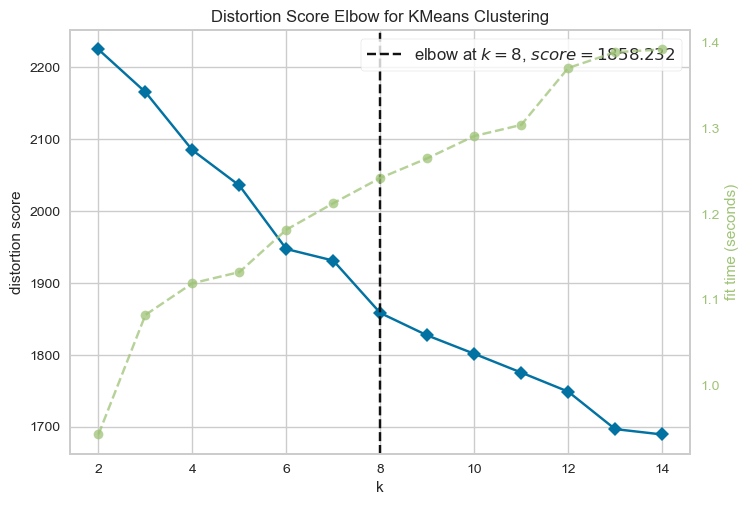

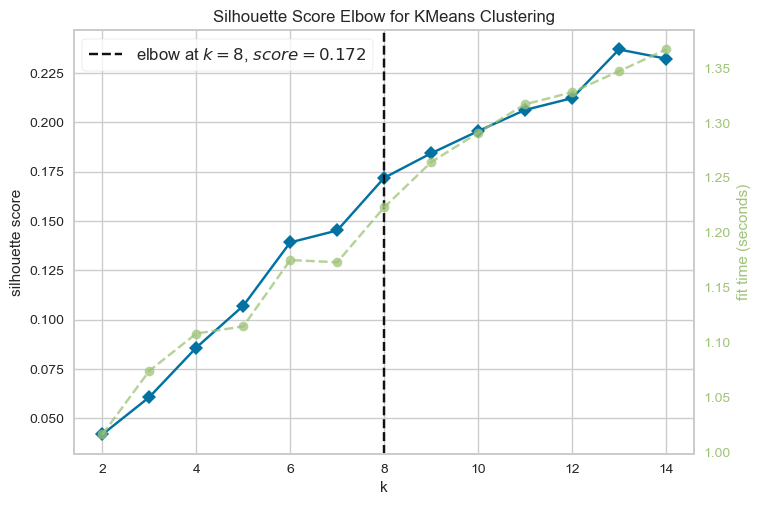

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [34]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

#Using the distortion and silhouette score as an evaluation metric
visualizer = KElbowVisualizer(model, metric =  'distortion',k=(2,15))
visualizer.fit(X_tfidf)  
visualizer.show()
visualizer = KElbowVisualizer(model, metric =  'silhouette',k=(2,15))
visualizer.fit(X_tfidf)  
visualizer.show()

In [35]:
# The model shows that 8 clusters are optimal
model = KMeans(n_clusters= 8, random_state=42)
model.fit(X_tfidf)

# Gather the predictions
preds = model.predict(X_tfidf)
score = metrics.silhouette_score(X_tfidf, preds)
score

0.17191925789787155

Dimensionality reduction using LSA

In [36]:
lsa = make_pipeline(TruncatedSVD(n_components=8), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)

Text(0.5, 1.0, 'Projection of the clustering on a the axis of the PCA')

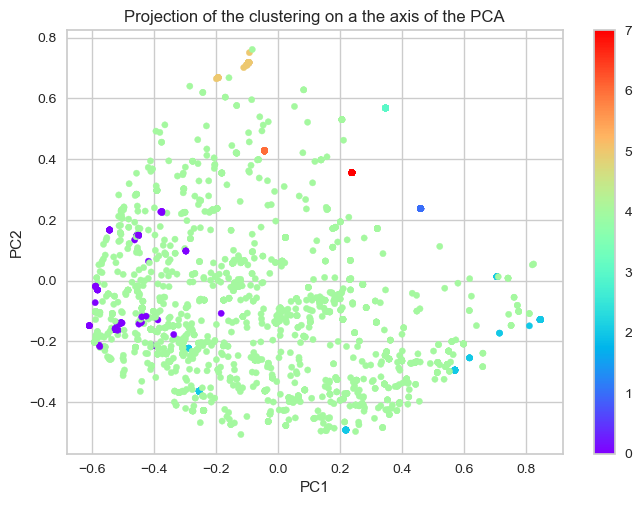

In [38]:
pca = PCA(n_components=8)
data_reduced = pca.fit_transform(X_lsa)
data_reduced = pd.DataFrame(data_reduced)

ax = data_reduced.plot(kind='scatter', x=0, y=1, c=preds, cmap='rainbow')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Projection of the clustering on a the axis of the PCA')

##### Transforming text via CountVectorizer

In [39]:
#Feature extraction using CountVectorizer
vectorizer_CountVectorizer = CountVectorizer(stop_words="english")
X_CV = vectorizer_CountVectorizer.fit_transform(df.text_tokenized)

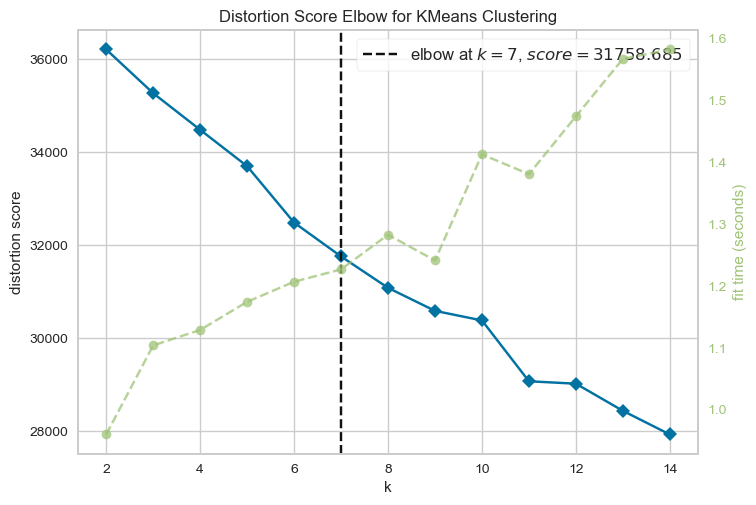

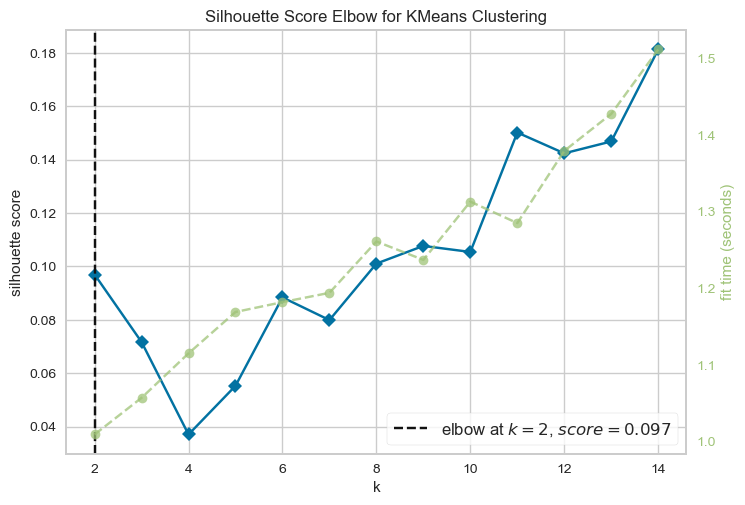

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [40]:
# Using the elbow method and distortion score as an evaluation metric
visualizer = KElbowVisualizer(model, metric = 'distortion',k=(2,15))
visualizer_sil = KElbowVisualizer(model, metric = 'silhouette',k=(2,15))
visualizer.fit(X_CV)  
visualizer.show()
visualizer_sil.fit(X_CV) 
visualizer_sil.show()

In [41]:
# The model shows that 5 clusters are optimal
model_cv = KMeans(n_clusters=3, random_state=42)
model_cv.fit(X_CV)

# Gather the predictions
preds_cv = model_cv.predict(X_CV)
score_cv = metrics.silhouette_score(X_CV, preds_cv)
score_cv

0.07171442170604779

In [42]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

lsa_cv = make_pipeline(TruncatedSVD(n_components=3), Normalizer(copy=False))

X_lsa_cv = lsa_cv.fit_transform(X_CV)

Text(0.5, 1.0, 'Projection of the clustering on a the axis of the PCA')

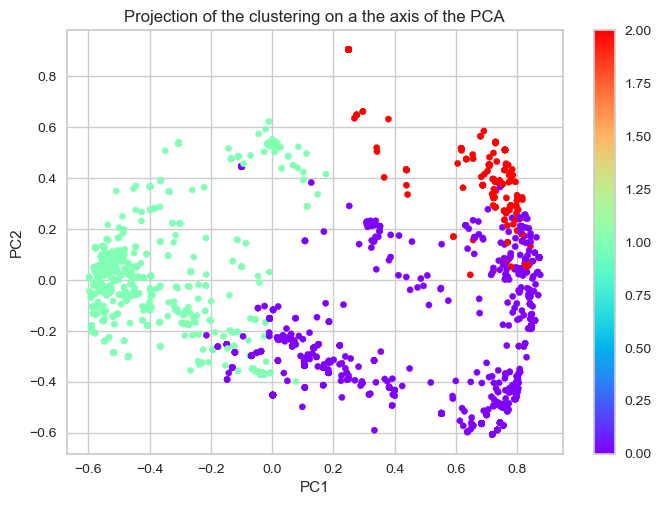

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
data_reduced_cv = pca.fit_transform(X_lsa_cv)
data_reduced_cv = pd.DataFrame(data_reduced_cv)

ax = data_reduced_cv.plot(kind='scatter', x=0, y=1, c=preds_cv, cmap='rainbow')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Projection of the clustering on a the axis of the PCA')

In [119]:
#Create dataframe with assigned cluster values to each row
df['clusters'] = pd.Series(preds_cv, index=df.index)

Clustered dataframe EDA 

In [122]:
#DF Summary statistics
df.describe()

,word_cnt,char_cnt,retweet_count,reply_count,like_count,quote_count,clusters
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,20.651250,154.777917,2920.248750,0.224167,0.547917,0.025833,0.775000
std,6.545926,48.190624,5233.879887,1.783323,7.714489,0.511802,0.632093
min,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,140.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,140.000000,183.500000,0.000000,0.000000,0.000000,1.000000
75%,23.000000,144.000000,4170.000000,0.000000,0.000000,0.000000,1.000000
max,63.000000,382.000000,33630.000000,55.000000,238.000000,24.000000,2.000000


In [127]:
#Summary counts of all metrics
cluster_metrics = df.groupby('clusters').sum().T.unstack().reset_index().rename(columns={0:'Total tweets','clusters':'Cluster','level_1':'Metric'})
cluster_metrics

,Cluster,Metric,Total tweets
0,0,word_cnt,16327
1,0,char_cnt,125695
2,0,retweet_count,1633962
3,0,reply_count,332
4,0,like_count,1030
5,0,quote_count,17
6,1,word_cnt,27078
7,1,char_cnt,186177
8,1,retweet_count,4922418
9,1,reply_count,4


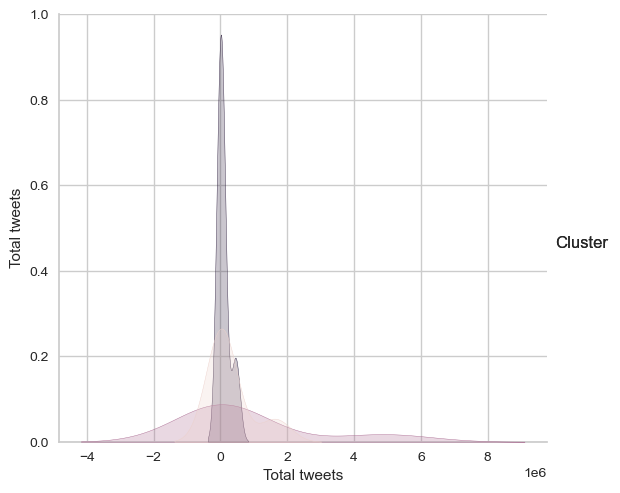

In [128]:
#View distribution of tweets by cluster
sns.pairplot(cluster_metrics, hue="Cluster", size=5).add_legend()

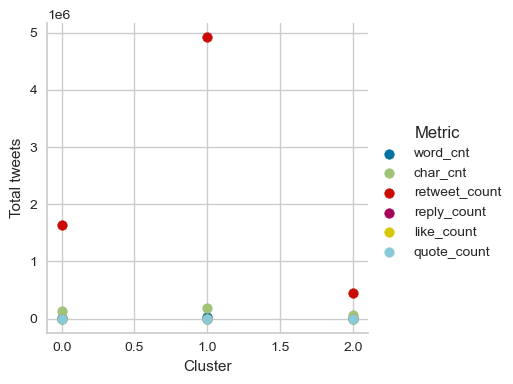

In [129]:
# View tweet metric by cluster and total tweets
import matplotlib.pyplot as plt
sns.FacetGrid(cluster_metrics, hue="Metric", size=4) \
   .map(plt.scatter, "Cluster", "Total tweets") \
   .add_legend();

#### Hierarchical Clustering Analysis

Another clustering method..

In [87]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

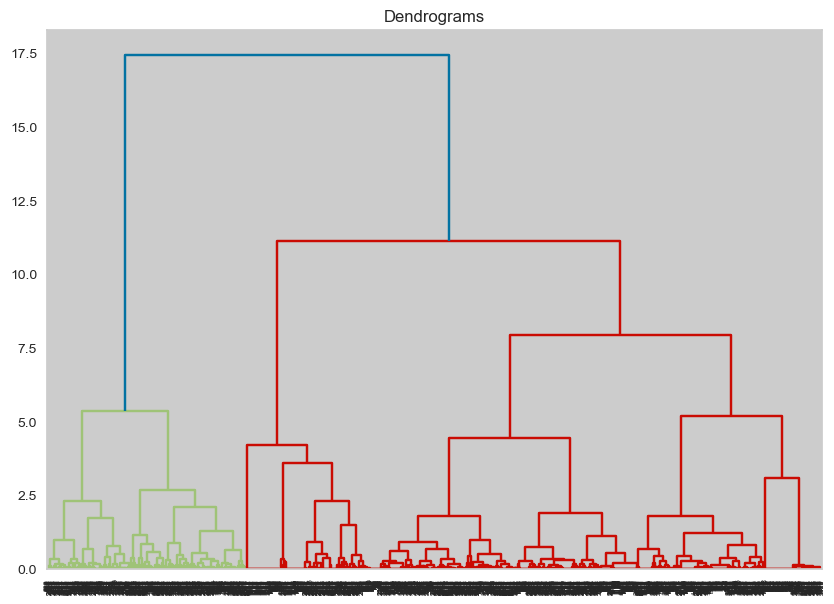

In [91]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_reduced_cv, method='ward'))

In [92]:
#Predict using denogram clusters
from sklearn.cluster import AgglomerativeClustering

#Fit using cv tokenized dataframe
cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
cluster.fit_predict(data_reduced_cv)

array([3, 3, 0, ..., 6, 0, 2], dtype=int64)

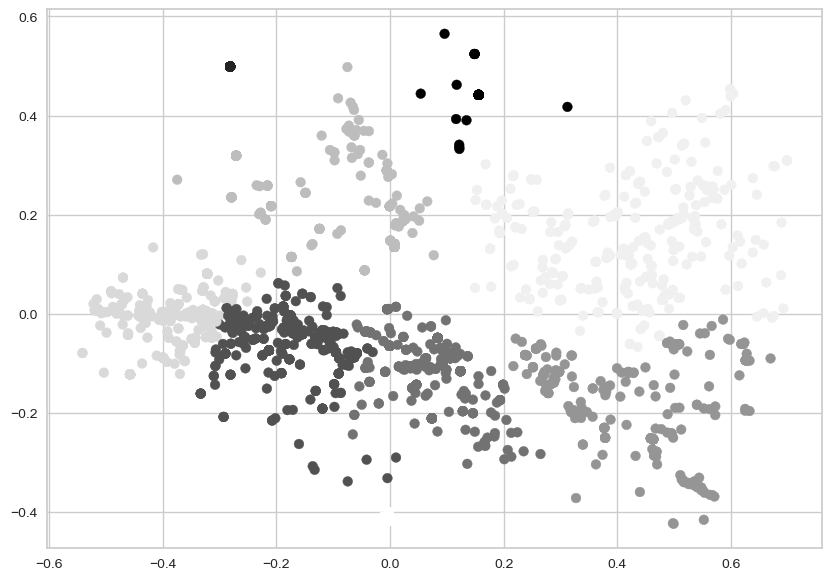

In [95]:
#View dendrogram clusters
plt.figure(figsize=(10, 7))  
plt.scatter(data_reduced_cv[0], data_reduced_cv[1], c=cluster.labels_) 

This exercise demonstrated an unsupervised machine learning analysis of Twitter data through leveraging various data science concepts. The collection of Twitter data was done through the developer API, which returned 2400 tweets that contain the hashtag ETH. This data was cleaned and transformed for text analysis through typical cleaning packages like pandas and re. Model development was intended to demonstrate two clustering approaches, K means and hierarchical clustering, and two types of vectorization methods; TfidfVectorizer and CountVectorizer. Finally, dimensionality reduction using latent semantic analysis and scoring through silhouette and distortion methods. 
Determining the appropriate number of clusters varied with each query to Twitter, implying that the data collected is very “loud.” Throughout the analysis, I struggled with the reproducibility of the results. However, there are ways to correct this, but because this was for demonstration purposes, I  didn’t want to get lost in hyper parameterization or additional data preprocessing. The best performing Kmeans combination was with the use of TfidfVectorizer and evaluation using the distortion score; the distortion score provided a better metric to go by than silhouette for this analysis. The hierarchical clustering method provided well-defined clusters; visually speaking, they are better than the K means visuals.  
In future analysis, if not the next step, it would be essential to drill into each cluster for analysis. Preliminary thoughts on this are that cluster 2 (from the cluster EDA performed at the bottom) contains many reply tweets; removing these may allow us to analyze actual discourse. 


- Clustering text documents using K-means. scikit. (n.d.). Retrieved October 3, 2022, from https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py 
- KeithxKeithx 2, & Gal DreimanGal Dreiman 3. (1963, November 1). How to add K-means predicted clusters in a column to a dataframe in python. Stack Overflow. Retrieved October 3, 2022, from https://stackoverflow.com/questions/38372188/how-to-add-k-means-predicted-clusters-in-a-column-to-a-dataframe-in-python 
- Source code for nltk.stem.wordnet. NLTK. (n.d.). Retrieved October 3, 2022, from https://www.nltk.org/_modules/nltk/stem/wordnet.html#WordNetLemmatizer 
